### Carregando as bibliotecas

Para a plataforma Windows, utilize a versão 4.0.0 do Pillow, utilizando o seguinte comando para instalar ```conda install -c anaconda pillow ```.

A instalação do Keras é pelo comando ```conda install -c anaconda keras```. Automaticamente será instalado as dependâncias como  _TensorFlow_.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications import ResNet50
from keras.applications import VGG16
#from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [3]:
keras.__version__

'2.2.4'

### Criando os geradores

Foram utilizadas imagens com tamanho 100 x 100 pixels, 1409 imagens por classe para o treinamento e 472 imagens por classe para validação.

Os geradores utilizados foram aplicados para converter o tamanho adequado do modelo utilizado (224 x 224 pixels) como também para criar novos exemplos a partir das imagens no que chamamos de _data augmentation_, por meio de perturbações da imagem baseado em recorte (```shear```), zoom e orientação horizontal (```horizontal_flip```).

Conjunto de dados utilizado foi [este](https://www.kaggle.com/moltean/fruits), disponível no Kaggle.

*Adaptado deste [artigo](https://medium.freecodecamp.org/keras-vs-pytorch-avp-transfer-learning-c8b852c31f02), de Patryk Miziula*

Com a técnica de _data augmentation_ foram geradas 1212 imagens por classe. Ao todo, o número de imagens subiu de 794 para 2424.

In [4]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "imagens-frutas/train",
    batch_size=32,
    class_mode="binary",
    color_mode='rgb',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    "imagens-frutas/validation",
    shuffle=False,
    class_mode="binary",
    color_mode='rgb',
    target_size=(224,224))

Found 1409 images belonging to 3 classes.
Found 473 images belonging to 3 classes.


In [5]:
train_generator.class_indices

{'Apple Braeburn': 0, 'Avocado': 1, 'Banana': 2}

### Construindo a rede neural baseado em modelo pré-treinado

O Keras já possui classes especializadas para os seguintes modelos de deep-learning treinados com o conjunto de dados [ImageNet](http://www.image-net.org/):
  
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

Mais detalhes, veja na [documentação do Keras](https://keras.io/applications/).

_O Keras se encarrega de baixar o modelo automaticamente, não é preciso baixar separadamente._

Note que o parâmetro ```include_top=False``` configura o modelo para não utilizar a camada densa original, pois será substituída pelas novas classes.

In [13]:
conv_base = VGG16(include_top=False)

for layer in conv_base.layers:
    layer.trainable = False

Removendo a camada densa para que seja adaptada para lidar com apenas 2 classes.

In [14]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [15]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Treinamento do modelo

In [16]:
history = model.fit_generator(generator=train_generator, 
                              epochs=3, 
                              validation_steps=5, 
                              steps_per_epoch=5, 
                              validation_data=validation_generator)

Epoch 1/3
5/5 [==============================] - 124s 25s/step - loss: 1.7468 - acc: 0.5438 - val_loss: 2.3187e-05 - val_acc: 1.0000
Epoch 2/3
5/5 [==============================] - 131s 26s/step - loss: 0.0193 - acc: 0.9938 - val_loss: 0.0745 - val_acc: 0.9688
Epoch 3/3
5/5 [==============================] - 127s 25s/step - loss: 0.0083 - acc: 1.0000 - val_loss: 1.0052e-04 - val_acc: 1.0000


### Armazenamento e carregamento do modelo

In [13]:
# salvando o modelo no formato HDf5
model.save('modelos/model-frutas.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights('modelos/weights-frutas.h5')
with open('modelos/architecture-frutas.json', 'w') as f:
    f.write(model.to_json())

In [8]:
# carregando o modelo no formato HDf5
model = load_model('modelos/model-frutas.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
with open('modelos/architecture-frutas.json') as f:
    model = model_from_json(f.read())
    
model.load_weights('modelos/weights-frutas.h5')

### Predição nas imagens de teste

In [17]:
validation_img_paths = ["imagens-frutas/validation/Apple Braeburn/7_100.jpg",
                        "imagens-frutas/validation/Avocado/49_100.jpg",
                        "imagens-frutas/validation/Banana/12_100.jpg",
                        "imagens/banana.jpeg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

Normalizando as imagens de teste, como neste caso não usamos o gerador do Keras, precisamos ajustar manualmente.

In [18]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224)).convert("RGB"))) for img in img_list])

In [19]:
pred_probs = model.predict(validation_batch)
pred_probs

array([[1.0000000e+00, 1.0384135e-13, 5.6501644e-17],
       [6.4700708e-02, 9.3529934e-01, 2.2518534e-09],
       [2.4113785e-06, 3.4748830e-08, 9.9999750e-01],
       [3.8487801e-06, 4.9779812e-11, 9.9999619e-01]], dtype=float32)

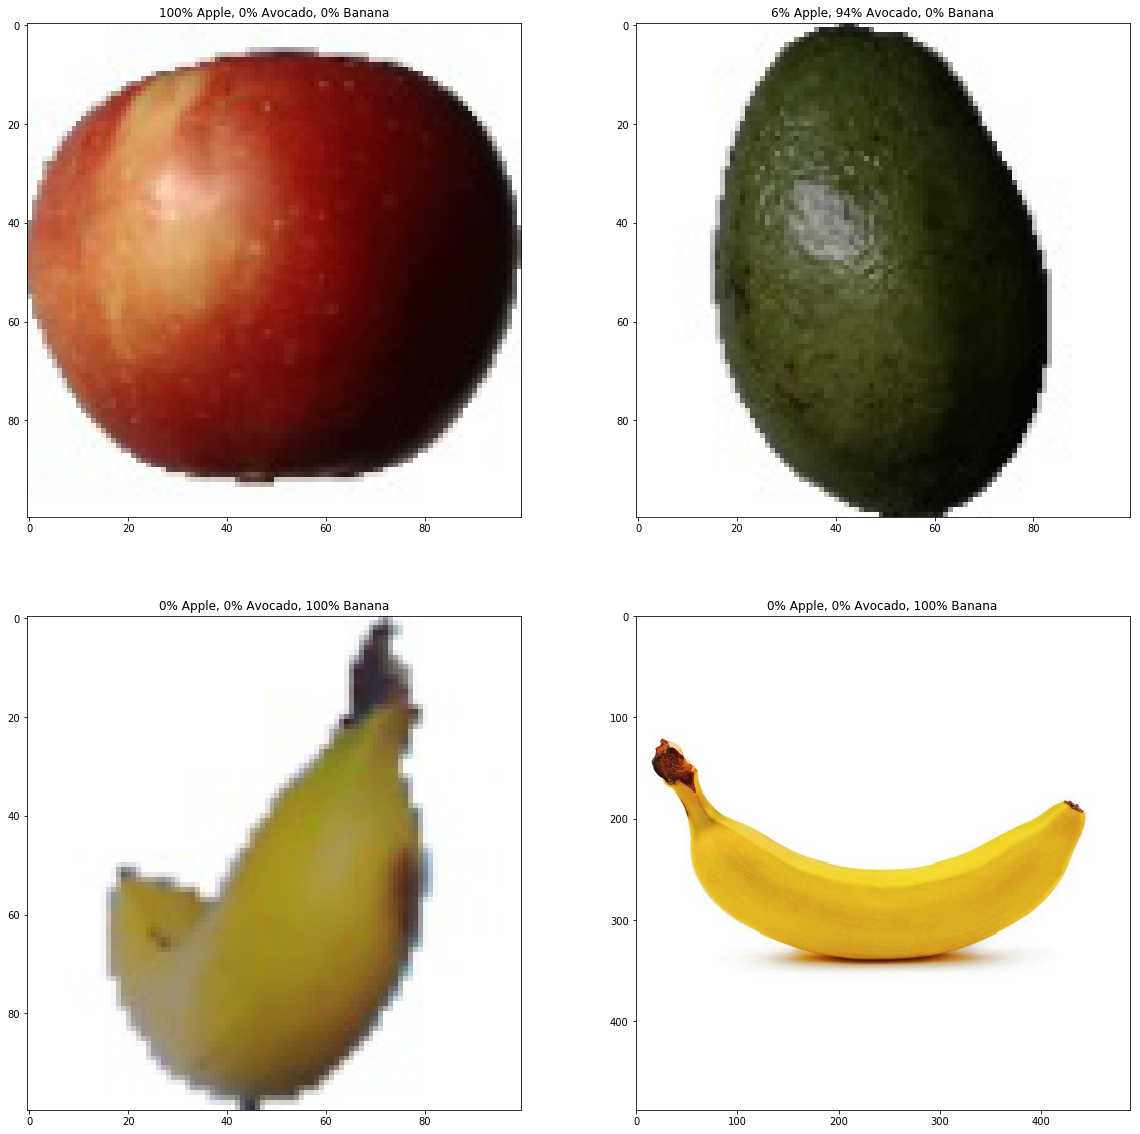

In [20]:
plt.figure(figsize=(20,20))

for i, img in enumerate(img_list):
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title("{:.0f}% Apple, {:.0f}% Avocado, {:.0f}% Banana".format(100*pred_probs[i,0], 100*pred_probs[i,1], 100*pred_probs[i,2]))